In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from lstm_class import Lstm
from sklearn.metrics import mean_squared_error

# Simulate Stock Prices

Stock prices shape: (101, 30)
Returns data shape: (100, 30)


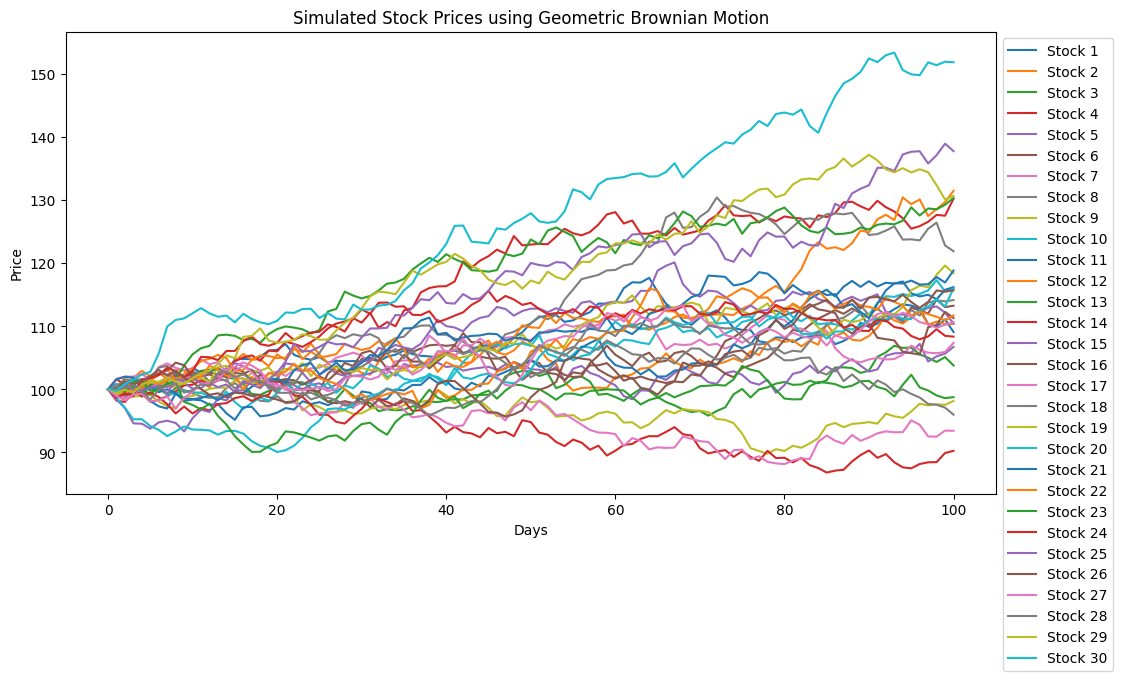

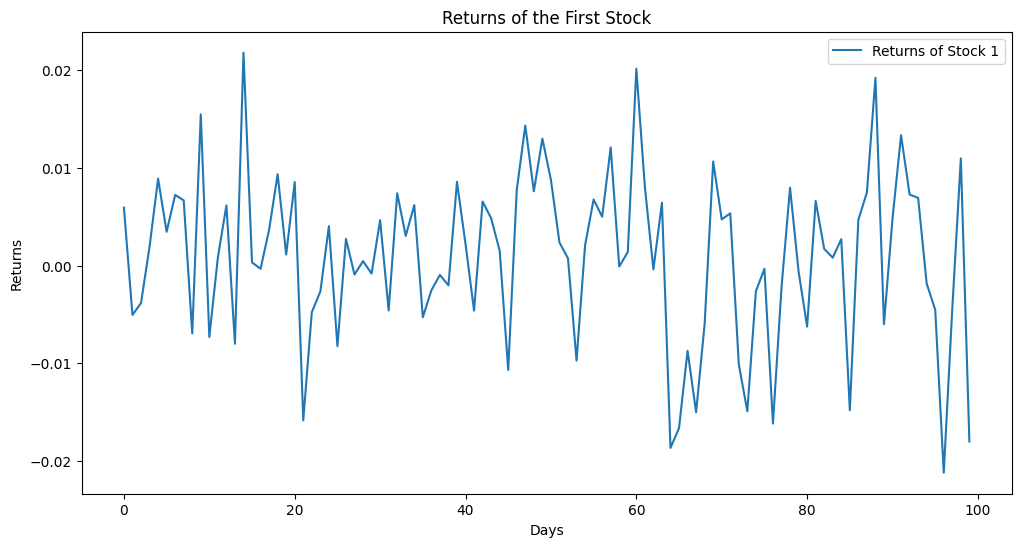

In [2]:
# Simulating Stock Prices
# Parameters for the GBM
num_stocks = 30
num_days = 101
mu = 0.001  # Drift coefficient
sigma = 0.01  # Volatility coefficient
S0 = 100  # Initial stock price

# Time vector
dt = 1  # Time increment (1 day)
t = np.linspace(0, num_days, num_days)

# Simulate stock prices
np.random.seed(42)
stock_prices = np.zeros((num_days, num_stocks))
stock_prices[0] = S0

for i in range(1, num_days):
    random_shocks = np.random.normal(0, 1, num_stocks)
    stock_prices[i] = stock_prices[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * random_shocks * np.sqrt(dt))

# Calculate returns
returns_data = np.diff(stock_prices, axis=0) / stock_prices[:-1]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
returns_data_scaled = scaler.fit_transform(returns_data)

# Print shapes to verify
print(f'Stock prices shape: {stock_prices.shape}')
print(f'Returns data shape: {returns_data.shape}')

# Plot the stock prices for visualization
plt.figure(figsize=(12, 6))
for i in range(num_stocks):
    plt.plot(stock_prices[:, i], label=f'Stock {i+1}')
plt.title('Simulated Stock Prices using Geometric Brownian Motion')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Plot the returns for one of the stocks for visualization
plt.figure(figsize=(12, 6))
plt.plot(returns_data[:, 0], label='Returns of Stock 1')
plt.title('Returns of the First Stock')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Prepare Data for each asset

In [3]:
# Split the data into train and test sets (70% train, 30% test)
train_size = int(len(returns_data_scaled) * 0.7)
train, test = returns_data_scaled[:train_size], returns_data_scaled[train_size:]

# Function to create sequences
def create_sequences(data, sequence_length=7):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [56]:
# Train Models for each Stock
models = {}
sequence_length = 7 # 70 Day Return Data
for i in range(num_stocks):
    stock_data = train[:, i].reshape(-1, 1) # Convert 1D array to 2D Vector
    lstm_model = Lstm(input_shape=(sequence_length, 1))
    X_train, y_train = create_sequences(stock_data, sequence_length)
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    lstm_model.fit(X_train, y_train)
    models[i] = lstm_model

Shape of X_train: (63, 7, 1)
Shape of y_train: (63, 1)
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2852
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2304 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1604 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0868 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0465 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0778 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0679 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0475 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0476 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0551 
Shape of X_train: (63, 7, 1)
Shape of y_train: (63, 1)
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2779
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2335 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2112 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1

In [61]:
# Store MSE
mse = {}
# Function to predict returns
def predict_returns(models, data, sequence_length=7):
    predicted_returns = []
    for i in range(num_stocks):
        model = models[i]
        stock_data = data[:, i].reshape(-1, 1)
        X_test, y_test = create_sequences(stock_data, sequence_length)
        print(f"For Stock {i + 1} Shape of X_test: {X_test.shape}")
        print(f"For Stock {i + 1} Shape of y_test: {y_test.shape}")
        predicted_return = model.model.predict(X_test)
        print(f"For Stock {i + 1} Shape of predicted_return: {predicted_return.shape}")
        mse_ = mean_squared_error(y_test, predicted_return.flatten())
        print(f"For Stock {i + 1} the MSE is {mse_}")
        mse[i] = mse_
        predicted_returns.append(predicted_return.flatten())
    return np.array(predicted_returns).T

# Predict returns using the LSTM models
predicted_returns = predict_returns(models, test, sequence_length)
# Rescale the predicted returns to original scale
#predicted_returns = scaler.inverse_transform(predicted_returns)
print(mse)

For Stock 1 Shape of X_test: (23, 7, 1)
For Stock 1 Shape of y_test: (23, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
For Stock 1 Shape of predicted_return: (23, 1)
For Stock 1 the MSE is 0.06591590830749854
For Stock 2 Shape of X_test: (23, 7, 1)
For Stock 2 Shape of y_test: (23, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
For Stock 2 Shape of predicted_return: (23, 1)
For Stock 2 the MSE is 0.04062840132363878
For Stock 3 Shape of X_test: (23, 7, 1)
For Stock 3 Shape of y_test: (23, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
For Stock 3 Shape of predicted_return: (23, 1)
For Stock 3 the MSE is 0.046169079817731336
For Stock 4 Shape of X_test: (23, 7, 1)
For Stock 4 Shape of y_test: (23, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
For Stock 4 Shape of predicted_return: (23, 1)
For Stock 4 the MSE is 0.04202191435970572
For Stock 5 Shape of X_test: (23, 7, 1)
For Stock 5 Shape of y_test: (23, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
For Stock 5 Shape of predicted_return: (23, 1)
For Stock 5 t

In [76]:
predicted_returns[:, 0]

array([0.34255192, 0.3226037 , 0.31295827, 0.33118212, 0.3533916 ,
       0.36072898, 0.36540306, 0.39570907, 0.4026443 , 0.38119948,
       0.3797511 , 0.39321855, 0.39765435, 0.40217093, 0.4092678 ,
       0.4196016 , 0.4580733 , 0.46262   , 0.456011  , 0.4243456 ,
       0.41849956, 0.39438853, 0.36827582], dtype=float32)

In [77]:
test[7:, :][:, 0]

array([0.44074406, 0.67853495, 0.47901142, 0.34785952, 0.64708967,
       0.5329658 , 0.51205532, 0.55610186, 0.148969  , 0.6020648 ,
       0.66744732, 0.94032018, 0.35363052, 0.60550071, 0.80359733,
       0.66229454, 0.65421352, 0.4504424 , 0.38798776, 0.        ,
       0.39098249, 0.74844   , 0.07432931])

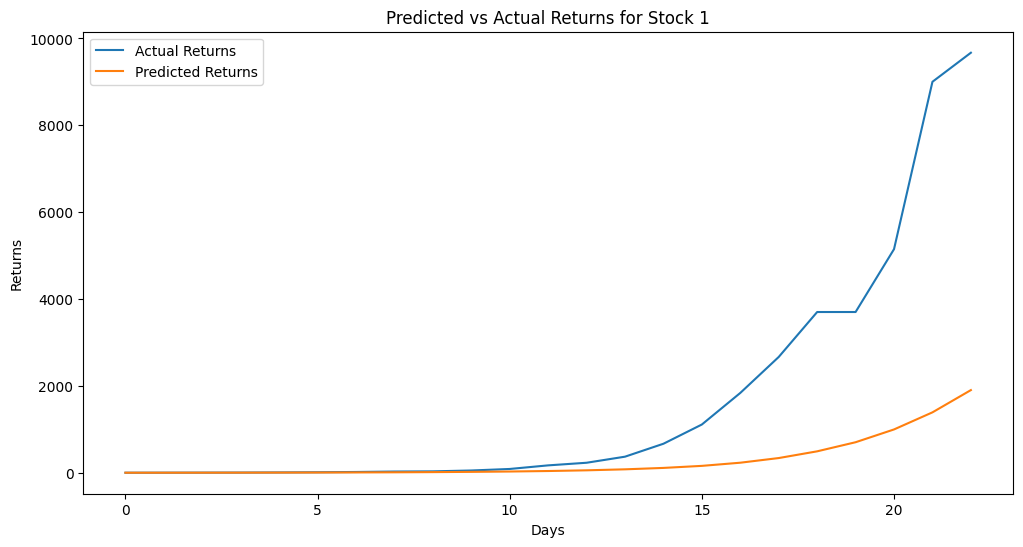

In [79]:
plt.figure(figsize=(12, 6))
plt.plot((1 + test[7:, :][:, 0]).cumprod(), label='Actual Returns')
plt.plot((1 + predicted_returns[:, 0]).cumprod(), label='Predicted Returns')
plt.title(f'Predicted vs Actual Returns for Stock 1')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

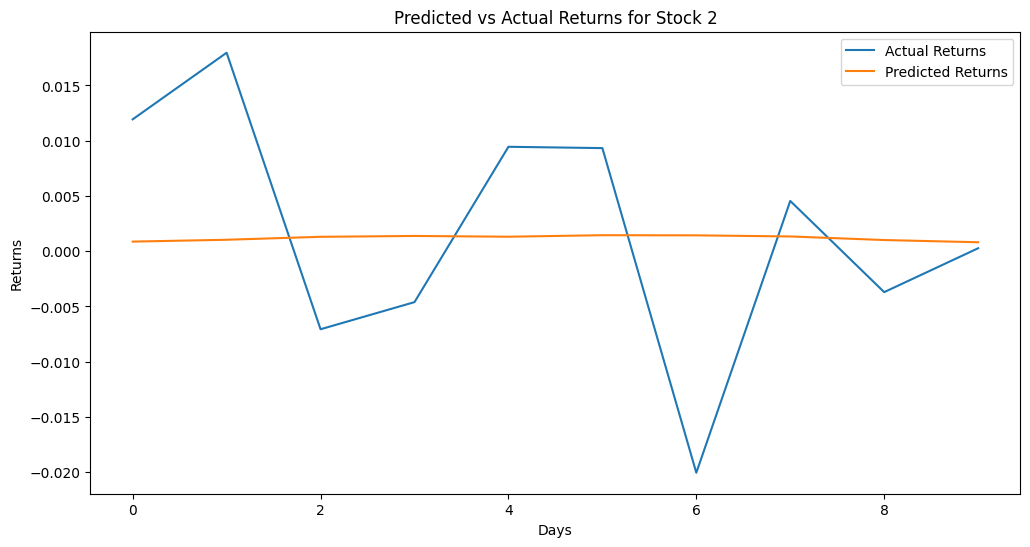

In [34]:
# Plot predicted vs actual returns for a single stock
stock_index = 1  # Change this index to plot for a different stock
actual_returns = scaler.inverse_transform(test[sequence_length:])[:, stock_index]

plt.figure(figsize=(12, 6))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns[:, stock_index], label='Predicted Returns')
plt.title(f'Predicted vs Actual Returns for Stock {stock_index + 1}')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [26]:
100 * (1 + actual_returns).cumprod()

array([100.48297108, 101.82412052, 102.56454546, 103.27471843,
       103.08498786, 102.61879314, 100.4428363 , 100.00152359,
       101.09909019,  99.27845484])

In [27]:
100 * (1 + predicted_returns[:, stock_index]).cumprod()

array([100.18336 , 100.39618 , 100.65903 , 100.98549 , 101.37521 ,
       101.78878 , 102.199196, 102.56307 , 102.86798 , 103.14479 ],
      dtype=float32)

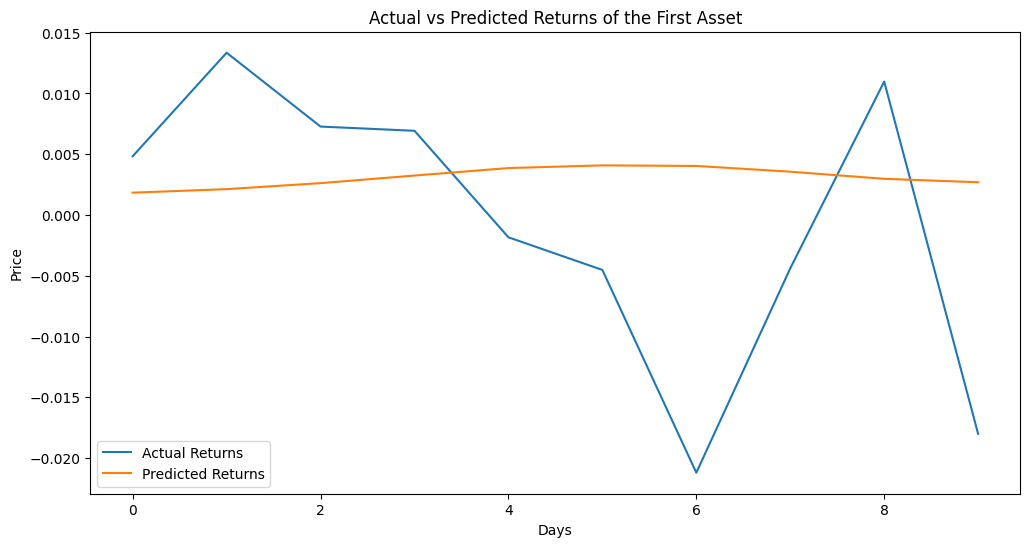

In [32]:
# Plot the actual vs predicted prices for the first asset
plt.figure(figsize=(12, 6))
plt.plot(actual_returns, label='Actual Returns')
plt.plot(predicted_returns[:, stock_index], label='Predicted Returns')
plt.title('Actual vs Predicted Returns of the First Asset')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

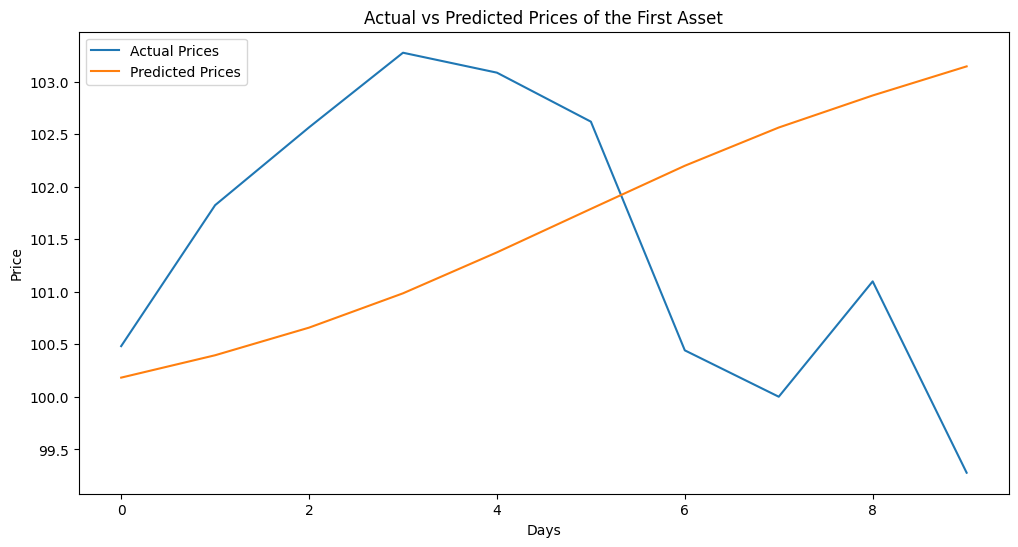

In [33]:
# Plot the actual vs predicted prices for the first asset
plt.figure(figsize=(12, 6))
plt.plot(100 * (1 + actual_returns).cumprod(), label='Actual Prices')
plt.plot(100 * (1 + predicted_returns[:, stock_index]).cumprod(), label='Predicted Prices')
plt.title('Actual vs Predicted Prices of the First Asset')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()